# Data exploratory analysis

The goal of this notebook is to explore the data and identify potential interesting insights

In [1]:
import pandas as pd
import numpy as np

# Statistics + plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## 1. Import data

In [2]:
# Open categories.cvs
categories = pd.read_csv('../project-4/data/clean-data/categories-post.csv')

# Explore data
categories.head()

,Unnamed: 0,Category,Sub-category,Keyword,Search Vol (min),Search Vol (max),Number of templates
0,0,Video,Facebook Video,Facebook Video template,23.076923,230.769231,145
1,1,Video,Social Feed Video Ad,Social Feed Video Ad template,2.307692,23.076923,159
2,2,Video,Pinterest Video Pin,Pinterest Video Pin template,2.307692,23.076923,21
3,3,Video,In-Stream Video Ad,In-Stream Video Ad template,2.307692,23.076923,149
4,4,Video,Youtube Intro,Youtube Intro template,230.769231,2307.692308,126


In [3]:
# Open .csv with Search trends and store them into a list of dics

csv_names = []
trends = {}

# Replace ' ' for '-'
for sub in categories['Sub-category']:
    csv_names.append(sub.replace(' ', '-').lower())
    
# Import .csv files
for name, sub in zip(csv_names, categories['Sub-category']):
    trends.update({sub: pd.read_csv(f'../project-4/data/clean-data/{name}.csv')})
    trends[sub].drop('Unnamed: 0', axis=1, inplace=True)
    
# Explore the data
trends['Instagram Ad']

,Date,Trend,isPartial,Category,Sub-category,Keyword,Search Vol (min),Search Vol (max),Number of templates,Search Vol (avge),Search Vol
0,2015-07-12,0,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1038,0.00
1,2015-07-19,0,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1038,0.00
2,2015-07-26,0,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1038,0.00
3,2015-08-02,0,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1038,0.00
4,2015-08-09,0,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1038,0.00
...,...,...,...,...,...,...,...,...,...,...,...
256,2020-06-07,44,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1038,456.72
257,2020-06-14,22,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1038,228.36
258,2020-06-21,45,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1038,467.10
259,2020-06-28,30,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1038,311.40


## 2. Merging tables for the analysis

In [6]:
for sub in trends:
    try:
        trends[sub]['Date'] = pd.to_datetime(trends[sub]['Date'])
    except:
        pass

## 3. Basic plotting

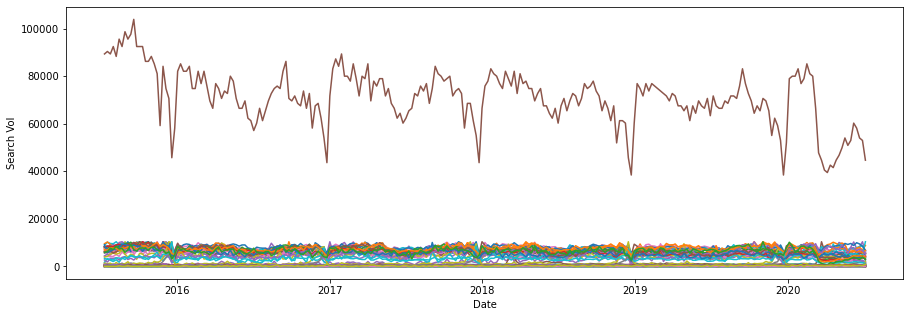

In [7]:
# Volume of searchs
plt.figure(figsize=(15,5))

for sub in trends:
    try:
    # Create a graph with the volume of searches
        ax = sns.lineplot(data=trends[sub], 
                          x='Date', 
                          y='Search Vol')
    except:
        pass

Resume sub-categorie has much more search vol than the rest. For the sake of the analysis, could be interesting to add those sub-categories with less than 10.000 monthly visits.

In [8]:
# Same plot with subcategories with less than 10.000 monthly searches on average
trends_gp = {'Under 1k': pd.DataFrame(columns=['Date', 'Search Vol']),
             'Under 10k': pd.DataFrame(columns=['Date', 'Search Vol']),
             'Under 100k': pd.DataFrame(columns=['Date', 'Search Vol'])}

# Aggregate DataFrames by groups depending on Search Vol.
for sub in trends:
    try:
        # Subcategories with an avge of less than 1k monthly seaches
        if (trends[sub]['Search Vol'].mean() < 1000):
            trends_gp['Under 1k'] = pd.concat([trends_gp['Under 1k'], trends[sub]])
        
        # Subcategories with an avge of less than 10k monthly seaches
        elif (trends[sub]['Search Vol'].mean() < 10000):
            trends_gp['Under 10k'] = pd.concat([trends_gp['Under 10k'], trends[sub]])
    
        # Subcategories with an avge of less than 100k monthly seaches
        elif ((trends[sub]['Search Vol'].mean() < 100000) & (trends[sub]['Search Vol'].mean() > 10000)):
            trends_gp['Under 100k'] = pd.concat([trends_gp['Under 100k'], trends[sub]])
            
        # The rest will be analysed individually
        else:
            trends_gp[sub] = trends[sub]

    except:
        pass
    
# Grouping by day and summing 'Seatch Vol.'
trends_gp['Under 1k'] = trends_gp['Under 1k'].groupby('Date', as_index=False).agg('sum')
trends_gp['Under 10k'] = trends_gp['Under 10k'].groupby('Date', as_index=False).agg('sum')
trends_gp['Under 100k'] = trends_gp['Under 100k'].groupby('Date', as_index=False).agg('sum')

In [9]:
# Checking the results
trends_gp['Under 100k'].head()

,Date,Search Vol,Trend,Search Vol (min),Search Vol (max),Number of templates,Search Vol (avge)
0,2015-07-12,89307.56,86.0,23076.923077,230769.230769,1483.0,103846.0
1,2015-07-19,90346.02,87.0,23076.923077,230769.230769,1483.0,103846.0
2,2015-07-26,89307.56,86.0,23076.923077,230769.230769,1483.0,103846.0
3,2015-08-02,92422.94,89.0,23076.923077,230769.230769,1483.0,103846.0
4,2015-08-09,88269.10,85.0,23076.923077,230769.230769,1483.0,103846.0


Now we have a dictionary with a DataFrame that aggregates the subcategories with less than 1k monthly searches as 'Under 1k', less than 10k monthly searches as 'Under 10k', a DataFrame that aggregates the subcategories with less that 100k monthly searches as 'Under 100k' and individual DataFrames for those subcategories with more than 100k monthly searches.

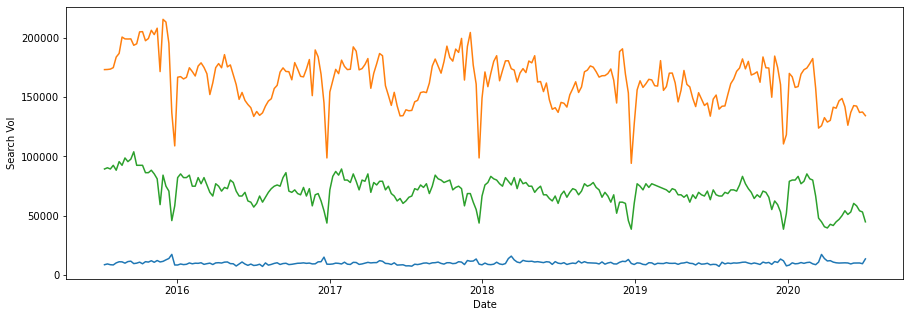

In [10]:
# Plot 
plt.figure(figsize=(15,5))

for sub in trends_gp:
    
    # Create a graph with the volume of searches
    ax = sns.lineplot(data=trends_gp[sub], 
                  x='Date', 
                  y='Search Vol')
    
## [BONUS] - Add legends

It would be useful to list the subcategories in each category.

In [11]:
# [BONUS] - List a summary with the categories in each bin. [Under 1k] | [Under 10k] | [Under 100k]

### Find 'Search Vol' trend

In [12]:
# Combine all searches and find the trend. 
# We will be able to compare each sub_category with the overall trend
# Statistical analysis

In [13]:
trends_gp['Total'] = pd.DataFrame(columns=['Date', 'Search Vol'])

# Concat all DataFrames into one
for sub in trends:
    trends_gp['Total'] = pd.concat([trends_gp['Total'], trends[sub]])

trends_gp['Total'] = trends_gp['Total'].groupby('Date', as_index=False).agg('sum')

#### Calculate the fitted line

In [14]:
# Create a constant
trends_gp['Total'] = sm.add_constant(trends_gp['Total'], has_constant='add')
trends_gp['Total'] = trends_gp['Total'].assign(t=range(1, len(trends_gp['Total']) + 1))
# sub_dic_gp['Total'] = sub_dic_gp['Total'].assign(t2=range(1, (len(sub_dic_gp['Total']) + 1)**2))

In [15]:
# Run OLS
X = trends_gp['Total'][["const", "t"]]
y = trends_gp['Total']["Search Vol"]

lin_reg = sm.OLS(y, X)
results_total = lin_reg.fit()

results_total.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Search Vol   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     61.88
Date:                Wed, 08 Jul 2020   Prob (F-statistic):           9.91e-14
Time:                        19:49:33   Log-Likelihood:                -3034.2
No. Observations:                 261   AIC:                             6072.
Df Residuals:                     259   BIC:                             6080.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.681e+05   3374.297     79.442      0.000    2.61e+05    2.75e+05
t           -175.6459     22.328     -7.866      0.000    -219.614    -131.678
==============================================================================
Omnibus:                       31.600   Durbin-Watson:                   0.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.194
Skew:                          -0.826   Prob(JB):                     1.13e-09
Kurtosis:                       4.030   Cond. No.                         303.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

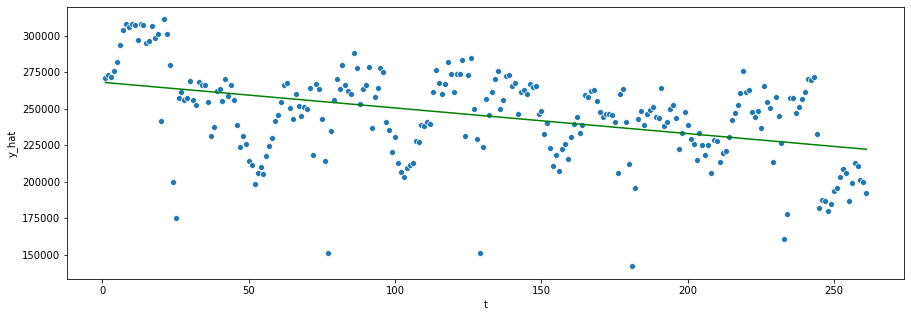

In [16]:
trends_gp['Total'] = trends_gp['Total'].assign(y_hat=results_total.predict(X))

plt.figure(figsize=(15,5))
    
sns.scatterplot(data=trends_gp['Total'], 
                x='t', 
                y='Search Vol');

sns.lineplot(data=trends_gp['Total'],
             x='t',
             y="y_hat",
             color="green");

In [17]:
# Find if there is a correlation between 'Templates' that Canva is offering and 'Search Vol' 
# We will be able to do a linear regression
# Statistical analysis

### 'Search Vol' vs. # 'Template '

Is there a correlation between the Search Vol for the Keywords assigned to the category and the number of templates that Canva is offering? Is it statistically significant?

We need to add a column with the Search Vol (avge) to the categories DataFrame

In [39]:
# Add a column with the Search Vol (avge)
categories['Search Vol (mean)'] = (categories['Search Vol (max)'] - categories['Search Vol (min)']) / 2 + categories['Search Vol (min)']

# Bonus, add the Search Vol with the trends

In [40]:
categories.head()

,Unnamed: 0,Category,Sub-category,Keyword,Search Vol (min),Search Vol (max),Number of templates,Search Vol (mean)
0,0,Video,Facebook Video,Facebook Video template,23.076923,230.769231,145,126.923077
1,1,Video,Social Feed Video Ad,Social Feed Video Ad template,2.307692,23.076923,159,12.692308
2,2,Video,Pinterest Video Pin,Pinterest Video Pin template,2.307692,23.076923,21,12.692308
3,3,Video,In-Stream Video Ad,In-Stream Video Ad template,2.307692,23.076923,149,12.692308
4,4,Video,Youtube Intro,Youtube Intro template,230.769231,2307.692308,126,1269.230769


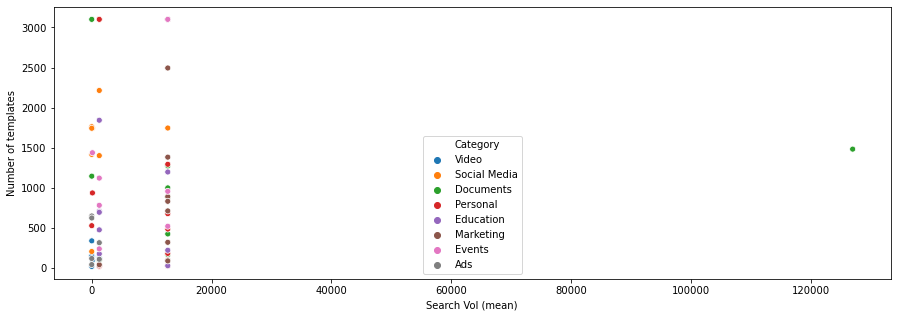

In [50]:
# Scatter plot to infere if it makes sense to calculate the fitted line
plt.figure(figsize=(15,5))
    
sns.scatterplot(data=categories, 
                x='Search Vol (mean)', 
                y='Number of templates',
                hue='Category');

In [46]:
# See if there is a correlation between the two variables
categories = sm.add_constant(categories, has_constant='add')

# Run OLS
lin_reg = sm.OLS(categories["Number of templates"],
                 categories[["const", "Search Vol (mean)"]])

result = lin_reg.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Number of templates   R-squared:                       0.015
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     1.054
Date:                 Wed, 08 Jul 2020   Prob (F-statistic):              0.308
Time:                         20:28:37   Log-Likelihood:                -589.68
No. Observations:                   71   AIC:                             1183.
Df Residuals:                       69   BIC:                             1188.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               317.4197     43.870      7.235      0.000     229.901     404.939
const               317.4197     43.870      7.235      0.000     229.901     404.939
const               317.4197     43.870      7.235      0.000     229.901     404.939
Search Vol (mean)     0.0078      0.008      1.027      0.308      -0.007       0.023
==============================================================================
Omnibus:                       11.848   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.552
Skew:                           1.070   Prob(JB):                      0.00114
Kurtosis:                       2.957   Cond. No.                     4.75e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.38e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [47]:
categories = categories.assign(y_hat=result.predict(categories[["const", "Search Vol (mean)"]]))

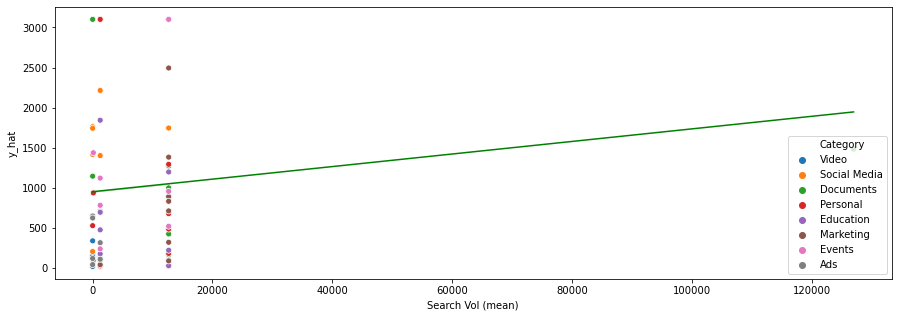

In [52]:
plt.figure(figsize=(15,5))
    
sns.scatterplot(data=categories, 
                x='Search Vol (mean)', 
                y='Number of templates',
                hue='Category');

sns.lineplot(data=categories,
             x='Search Vol (mean)',
             y="y_hat",
             color="g");